# import libraries 

In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import csv # raw dataset in csv

2.2.0-rc3


# define helper functions 

In [0]:
def plot_graphs(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('values')
  plt.grid(True)

def windowed_dataset(series, batch_size, window_size, shuffle_buffer_size):
  # add dimension to dataset at the end
  series = tf.expand_dims(series, axis=-1)
  # create synthetic series 
  # ds= dataset
  ds = tf.data.Dataset.from_tensor_slices(series)
  # partition dataset using windowing
  # size of window = window_size + 1 (to include label)
  # shift window by 1 after populating full dataset
  # drop_remainder= ensure all processed datasets are complete, drop partial datasets
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  # flatten into a numpy list per dataset batch of window_size+label for ML processing
  # use a Lambda to add arbitrary code
  # w= window
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  # shuffle/randomize dataset to reduce sequence bias 
  ds = ds.shuffle(shuffle_buffer_size)
  # map features and labels to numeric representations, 
    # labels = last value
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  # batch the features and respective labels together 
  return ds.batch(batch_size).prefetch(1)

# forecast/predict linear regression numeric values via trained model
def model_forecast(model, series, window_size):
  # create synthetic series 
  ds = tf.data.Dataset.from_tensor_slices(series)
  # partition dataset into windows
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  # flatten & map into a numpy list with each window of batch_size
  ds = ds.flat_map(lambda w: w.batch(window_size))
  # batch the feature and labels together
  ds = ds.batch(32).prefetch(1)
  # use model to forecast next value in series
  forecast = model.predict(ds)
  return forecast
  


# get dataset

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-23 13:00:50--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-04-23 13:00:50 (3.21 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [0]:
# format dataset 
tempertures = []
time_steps = []

# with open file_path, define reader(file, delimiter)
with open('/tmp/daily-min-temperatures.csv') as csv_file:
  reader = csv.reader(csv_file, delimiter=',')
  # skip to next row (disregard row of column names)
  next(reader)
  # iterate over each row in reader ds
  step = 0
  for row in reader:
    # convert into desired format
    temp = float(row[1])
    # populate lists
    tempertures.append(temp)
    time_steps.append(step)
    # continue to next step
    step += 1


# define hyperparameters

In [0]:
# convert datasets into numpy arrays for model processing
series = np.array(tempertures)
time = np.array(time_steps)

In [0]:
split_time = 1000
batch_size = 256
shuffle_buffer_size = 1000

the window defines the number of raw observations by zooming in on a specific timeframe
- windowing is commonly used to calculate the moving average value.

In [0]:
window_size = 64

# visualize baseline 

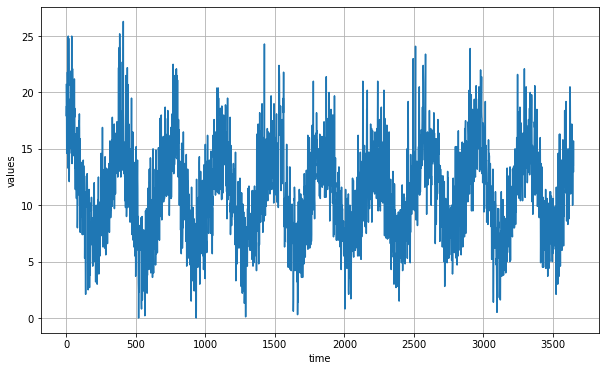

In [0]:
plt.figure(figsize=(10,6))
plot_graphs(time, series)

# split dataset into train & validation subsets

In [0]:
time_train = time[:split_time]
x_train = series[:split_time]

time_validation = time[split_time:]
x_validation = series[split_time:]

print(x_train.shape)
print(x_validation.shape)

(1000,)
(2650,)


# define callbacks



In [0]:
# instantiate LearningRateScheduler to optimize LR after each epoch
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

class myCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('loss') < 0.01:
      print('\ntrain loss < 0.01, stopping training')
      self.model.stop_training = True

# instantiate custom callbacks 
callbacks = myCallbacks()

# define the pre-train model

this model is for identifying optimal learning rate

In [0]:
# reset memory values to avoid side effects 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
# get windowed ds for optimal learning rate
lr_dataset = windowed_dataset(x_train, batch_size, window_size, shuffle_buffer_size)

**padding="causal"**

This simply pads the layer's input with zeros in the front so that we can also predict the values of early time steps in the frame:

![](https://i.stack.imgur.com/NmYZJ.png)

In [0]:
model = tf.keras.Sequential([
  # input layer = need to define input_shape
  # 32 5x5 filters/neurons detecting unique patterns
  # padding=causal, pads the layer's input with zeros in the front 
    # so that we can also predict the values of early time steps in the frame
  # relu= return x if x > 0, else return 0                               
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', strides=1, padding='causal', input_shape=[None, 1]),
  # LSTM layer maintains memory cell state for context both forward & backward
  # return_sequences= feeding LSTM layer output matches receiving LSTM layer input
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
  # no need to flattening layer since windowed_dataset helper function already does this
  # fully connected dense layer maps input to outputs by id optimal weights/relationships 
  tf.keras.layers.Dense(units=30, activation='relu'),
  # get more granular weights/relationships
  tf.keras.layers.Dense(units=10, activation='relu'),
  # output layer uses optimized weights to predict single linear regression numeric value
  tf.keras.layers.Dense(units=1),
  # use lambda to execute custom functionality that enlargens values
  tf.keras.layers.Lambda(lambda x: x * 400)
])

'''
Total params: weights + hyperparameters
Trainable params: weights
Non-trainable params: hyperparameters
'''

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3870      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

# compile the model 

build the model by compiling it with a loss, optimizer, and objective metric

---
**Huber Loss:**

`Huber loss is less sensitive to outliers in data than the squared error loss.`
- It’s basically absolute error, which becomes quadratic when error is small.

However, the problem with Huber loss is that we might need to train hyperparameter delta which is an iterative process.

In [0]:
# sgd= stochastic gradient descent optimizes at each time_step
sgd = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
# mae is great metric if you don't want to heavily punish large errors 
model.compile(loss=tf.keras.losses.Huber(), optimizer=sgd, metrics=['mae'])

# train the model for optimal LR

.fit() the model to train & learn the optimal weights/relationships 

assign results to history var for performance querying

In [0]:
history = model.fit(lr_dataset, epochs=100, callbacks=[lr_scheduler], verbose=0)

# visualize optimal learning rate

(1e-08, 0.0001, 0.0, 60.0)

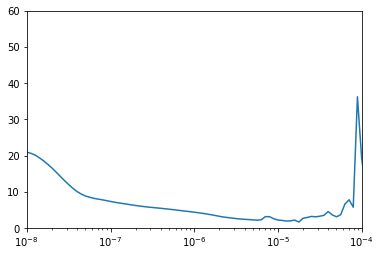

In [0]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

# reset env for model training 

In [0]:
# reset memory values to avoid side-effects 
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
batch_size = 60
window_size = 100
# get windowed ds
train_dataset = windowed_dataset(x_train, batch_size, window_size, shuffle_buffer_size)

# define the training model

this model will use the optimal learning rate

In [0]:
model = tf.keras.Sequential([
  # input layer = need to define input_shape
  # 32 5x5 filters/neurons detecting unique patterns
  # padding=causal, pads the layer's input with zeros in the front 
    # so that we can also predict the values of early time steps in the frame
  # relu= return x if x > 0, else return 0                               
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', strides=1, padding='causal', input_shape=[None, 1]),
  # LSTM layer maintains memory cell state for context both forward & backward
  # return_sequences= feeding LSTM layer output matches receiving LSTM layer input
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
  # no need to flattening layer since windowed_dataset helper function already does this
  # fully connected dense layer maps input to outputs by id optimal weights/relationships 
  tf.keras.layers.Dense(units=30, activation='relu'),
  # get more granular weights/relationships
  tf.keras.layers.Dense(units=10, activation='relu'),
  # output layer uses optimized weights to predict single linear regression numeric value
  tf.keras.layers.Dense(units=1),
  # use lambda to execute custom functionality that enlargens values
  tf.keras.layers.Lambda(lambda x: x * 400)
])

'''
Total params: weights + hyperparameters
Trainable params: weights
Non-trainable params: hyperparameters
'''

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3870      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

# compile the model with optimized learning rate

build the model by compiling it with a loss, optimizer, and objective metric

---
**Huber Loss:**

`Huber loss is less sensitive to outliers in data than the squared error loss.`
- It’s basically absolute error, which becomes quadratic when error is small.

However, the problem with Huber loss is that we might need to train hyperparameter delta which is an iterative process.

In [0]:
optimized_lr = 1e-5
sgd = tf.keras.optimizers.SGD(learning_rate=optimized_lr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=sgd, metrics=['mae'])

# train the model

In [0]:
history = model.fit(train_dataset, epochs=500, callbacks=[callbacks], verbose=1)

# get trained-model forecast results

newaxis= increase the dimension of the existing array by one more dimension

---

**example:** 

if array= `(4,) aka (4, None)` 

*make it as column vector by inserting an axis along second dimension*

```
new_column_vectors = array[:, np.newaxis]
new_column_vectors.shape = (4, 1)
```

if array= `(, 4) aka (None, 4)` 

*make it as row vector by inserting an axis along first dimension*

```
new_row_vectors = [np.newaxis, :]
new_row_vectors.shape = (1, 4)
```

---



In [0]:
# newaxis= increase the dimension of the existing array by one more dimension
  # increase the row vector by inserting an axis along first dimension
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# only get validation ds + window leading up to validation ds
# -1= labels
predicted_results = rnn_forecast[split_time-window_size:-1, -1, 0]

# visualize forecast results against validation dataset

use time validation

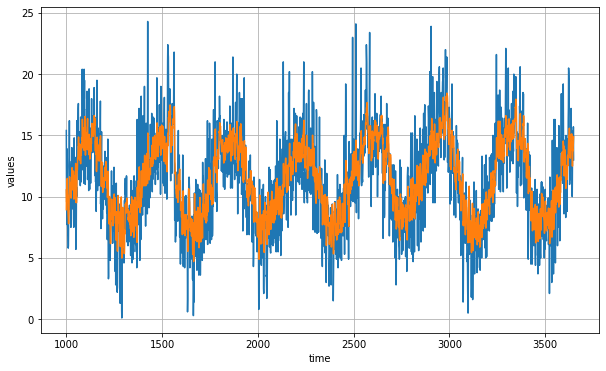

In [0]:
plt.figure(figsize=(10,6))
plot_graphs(time_validation, x_validation)
plot_graphs(time_validation, predicted_results)

# get loss

`convert into numpy since ML love that format` 

mae= mean absolute deviation/error
- we use absolute values and not penalize large errors as much

In [0]:
print('mae: {}'.format(tf.keras.metrics.mean_absolute_error(x_validation, predicted_results).numpy()))

mae: 1.9307737350463867


# clean up

terminate memory kernel and free up resources 

In [0]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)